In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/potency/potency.csv
/kaggle/input/potency2/potency2.csv


# Predicting THC Content in Cannabis Distillates Using CBN Values: Addressing the THC Inflation Problem

## Introduction:

The burgeoning cannabis industry has witnessed exponential growth in recent years, fueled by the increasing legalization of cannabis for medicinal and recreational use across the globe. However, this rapid expansion has brought to light a concerning issue known as "THC inflation." THC, or delta-9-tetrahydrocannabinol, is the primary psychoactive compound found in cannabis, and its potency plays a crucial role in product quality and consumer safety.

THC inflation refers to the phenomenon where the reported THC content in cannabis products, particularly distillates, significantly exceeds the actual levels. This discrepancy has raised concerns among both the public and Licensed Producers (LPs), prompting efforts to address this pressing issue. Inflated THC levels can mislead consumers, compromise their experiences, and impact their overall perception of cannabis products. Additionally, it can undermine regulatory compliance and consumer trust in the industry.

Efforts to mitigate THC inflation involve a multifaceted approach, encompassing collaboration between LPs, consumers, and regulatory bodies. Among the various strategies proposed, a promising avenue is the use of advanced data analysis techniques and machine learning models to predict THC content accurately. Such models leverage data from potency testing, offering an alternative means of verification while reducing reliance on reported THC values.

This project focuses on one such innovative approach, aiming to use Cannabinol (CBN) values to predict THC levels in cannabis distillates with an impressive 92% accuracy rate. The dataset employed for this project comprises in-house potency results for approximately 500 distillate samples, meticulously generated by BZAM Management Inc.. This extensive dataset is instrumental in developing a robust predictive model.

The project commenced with a comprehensive Exploratory Data Analysis (EDA) phase, revealing a significant negative correlation (-0.83) between CBN and delta-9-THC (d9-THC) for distillates. This correlation suggests that as CBN levels rise, d9-THC levels tend to decrease, reflecting the natural degradation of THC over time due to exposure to high temperature, oxygen and light. Understanding this relationship is pivotal in the development of an accurate predictive model.

To build the predictive model, the dataset was divided into training and test sets, with 70% used for training and 30% for testing. The model was optimized using polynomial features, ensuring it captures the complex interplay between CBN and THC content in cannabis distillates.

In conclusion, addressing the issue of THC inflation in the cannabis industry is of paramount importance for the integrity and sustainability of the market. This project represents a significant step in the right direction by harnessing the power of machine learning to predict THC values accurately using CBN data, offering a potential solution to mitigate THC inflation and enhance transparency in the industry. The subsequent sections of this paper delve into the methodology, results, and implications of this groundbreaking approach, shedding light on its potential to reshape the cannabis testing landscape.

In [2]:
# Dataset from BZAM Management Inc. In-house potency testing data
df1 = pd.read_csv('../input/potency/potency.csv')
df2 = pd.read_csv('../input/potency2/potency2.csv')

# EDA

In [3]:
df2.tail()

,Date of Analysis,Source Batch/Lot,Sample ID,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
1408,21-12-2022,TDT-221216-01,RND-TDT-221216-01,881.6915,NaN,881.6915,88.1691,NaN,NaN,NaN,14.6322,NaN,52.8678,NaN,NaN,6.5294,955.7210
1409,21-12-2022,TDT-221216-01,RND-TDT-221216-11,869.5696,NaN,869.5696,86.9570,NaN,NaN,NaN,13.8446,NaN,52.9389,NaN,NaN,7.1816,943.5348
1410,21-12-2022,TDT-221220-01,RND-TDT-221220-01,870.1708,NaN,870.1708,87.0171,NaN,NaN,NaN,11.5117,NaN,54.1494,NaN,NaN,5.5937,941.4255
1411,21-12-2022,THO-221216-01,RND-THO-221216-01,770.5478,NaN,770.5478,77.0548,NaN,NaN,NaN,18.3146,NaN,70.9410,NaN,NaN,2.7388,862.5421
1412,21-12-2022,THO-221220-01,RND-THO-221220-01,759.1329,NaN,759.1329,75.9133,NaN,NaN,NaN,13.7357,NaN,75.7226,NaN,NaN,1.2752,849.8664


In [4]:
df1.drop(['Source Batch/Lot','Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20'], axis=1, inplace=True)

In [5]:
df2.drop(['Source Batch/Lot'], axis=1, inplace=True)

In [6]:
# Making sure the two dataframes have similar columns
df1.columns


Index(['Date of Analysis', 'Sample ID', ' ∆9-THC (mg/g)', 'THCA (mg/g)',
       'Total THC (mg/g)', 'THC Wt.%', 'CBD(mg/g)', 'CBDA (mg/g)',
       'Total CBD (mg/g)', 'CBNmg/g', ' ∆8-THCmg/g', 'CBGmg/g', 'CBGAmg/g',
       'THCVmg/g', 'CBCmg/g', 'Total'],
      dtype='object')

In [7]:
df2.columns

Index(['Date of Analysis', 'Sample ID', ' ∆9-THC (mg/g)', 'THCA (mg/g)',
       'Total THC (mg/g)', 'THC Wt.%', 'CBD(mg/g)', 'CBDA (mg/g)',
       'Total CBD (mg/g)', 'CBNmg/g', ' ∆8-THCmg/g', 'CBGmg/g', 'CBGAmg/g',
       'THCVmg/g', 'CBCmg/g', 'Total'],
      dtype='object')

In [8]:
df1 = df1.loc[df1['Date of Analysis'] <= '2023-05-19', :]

In [9]:
df2 = df2.loc[df2['Date of Analysis'] <= '21-12-2022', :]

In [10]:
print(df1.shape)
print(df2.shape)

(561, 16)
(1037, 16)


In [11]:
df_concat = pd.concat([df1, df2]).drop_duplicates()

In [12]:
df_concat.tail()

,Date of Analysis,Sample ID,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
1408,21-12-2022,RND-TDT-221216-01,881.6915,NaN,881.6915,88.1691,NaN,NaN,NaN,14.6322,NaN,52.8678,NaN,NaN,6.5294,955.7210
1409,21-12-2022,RND-TDT-221216-11,869.5696,NaN,869.5696,86.9570,NaN,NaN,NaN,13.8446,NaN,52.9389,NaN,NaN,7.1816,943.5348
1410,21-12-2022,RND-TDT-221220-01,870.1708,NaN,870.1708,87.0171,NaN,NaN,NaN,11.5117,NaN,54.1494,NaN,NaN,5.5937,941.4255
1411,21-12-2022,RND-THO-221216-01,770.5478,NaN,770.5478,77.0548,NaN,NaN,NaN,18.3146,NaN,70.9410,NaN,NaN,2.7388,862.5421
1412,21-12-2022,RND-THO-221220-01,759.1329,NaN,759.1329,75.9133,NaN,NaN,NaN,13.7357,NaN,75.7226,NaN,NaN,1.2752,849.8664


In [13]:
df_concat.shape

(1598, 16)

In [14]:
df_concat = df_concat.fillna(0)

In [15]:
df_concat.head(2)

,Date of Analysis,Sample ID,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
0,2023-01-04,RND-TFR-TROTR-221214-01,804.7104,0,804.7104,80.471,0.0,0.0,0.0,9.7238,0.0,48.2295,0.0,2.6931,8.1447,873.50
1,2023-01-04,RND-TFR-KINKU-221214-01,830.5386,0,830.5386,83.0539,0.0,0.0,0.0,7.3522,0.0,23.8471,0.0,2.3226,8.5475,872.61


In [16]:
df_concat.dtypes

Date of Analysis     object
Sample ID            object
 ∆9-THC (mg/g)       object
THCA (mg/g)          object
Total THC (mg/g)     object
THC Wt.%             object
CBD(mg/g)           float64
CBDA (mg/g)         float64
Total CBD (mg/g)    float64
CBNmg/g             float64
 ∆8-THCmg/g         float64
CBGmg/g             float64
CBGAmg/g            float64
THCVmg/g            float64
CBCmg/g             float64
Total               float64
dtype: object

In [17]:
# Changing the data types of numbers from string to numeric(float)

df_concat['THC Wt.%'] = pd.to_numeric(df_concat['THC Wt.%'], errors='coerce')
df_concat[' ∆9-THC (mg/g)'] = pd.to_numeric(df_concat[' ∆9-THC (mg/g)'], errors='coerce')
df_concat['THCA (mg/g)'] = pd.to_numeric(df_concat['THCA (mg/g)'], errors='coerce')
df_concat['Total THC (mg/g)'] = pd.to_numeric(df_concat['Total THC (mg/g)'], errors='coerce')

In [18]:
#Changing Date from string to date format
df_concat['Date of Analysis'] = pd.to_datetime(df_concat['Date of Analysis'], dayfirst=True)

In [19]:
df_concat.dtypes

Date of Analysis    datetime64[ns]
Sample ID                   object
 ∆9-THC (mg/g)             float64
THCA (mg/g)                float64
Total THC (mg/g)           float64
THC Wt.%                   float64
CBD(mg/g)                  float64
CBDA (mg/g)                float64
Total CBD (mg/g)           float64
CBNmg/g                    float64
 ∆8-THCmg/g                float64
CBGmg/g                    float64
CBGAmg/g                   float64
THCVmg/g                   float64
CBCmg/g                    float64
Total                      float64
dtype: object

In [20]:
df = df_concat

In [21]:
df.reset_index(drop=True, inplace=True)


In [22]:
df.set_index('Date of Analysis', inplace=True)

In [23]:
df.sort_values(by='Date of Analysis', inplace = True)

In [24]:
df.head()

,Sample ID,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
Date of Analysis,,,,,,,,,,,,,,,
2021-01-13,RND-DT-201215-01,905.4981,0.0,905.4981,90.5498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905.4981
2021-01-13,RND-DT-201214-01,915.9416,0.0,915.9416,91.5942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,915.9416
2021-01-13,RND-DT-201211-03,926.4238,0.0,926.4238,92.6424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926.4238
2021-01-13,RND-DT-210111-01,909.8991,0.0,909.8991,90.9899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,909.8991
2021-01-13,RND-DT-210111-02,893.6987,0.0,893.6987,89.3699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,893.6987


In [25]:
df.shape

(1598, 15)

In [26]:
df.corr()

/tmp/ipykernel_34/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
∆9-THC (mg/g),1.000000,-0.301001,0.968337,0.968337,-0.183231,-0.181661,-0.182531,-0.131679,0.005377,0.596583,-0.209386,0.174313,0.626314,0.932929
THCA (mg/g),-0.301001,1.000000,-0.053403,-0.053403,-0.007833,-0.000710,-0.002187,-0.031723,-0.003925,-0.224684,0.556868,-0.093342,-0.214097,-0.038385
Total THC (mg/g),0.968337,-0.053403,1.000000,1.000000,-0.193918,-0.190410,-0.191707,-0.146190,0.004602,0.565884,-0.073475,0.158093,0.599788,0.966854
THC Wt.%,0.968337,-0.053403,1.000000,1.000000,-0.193918,-0.190410,-0.191707,-0.146190,0.004602,0.565884,-0.073475,0.158093,0.599788,0.966854
CBD(mg/g),-0.183231,-0.007833,-0.193918,-0.193918,1.000000,0.981800,0.988512,-0.017880,-0.002290,-0.139885,0.132591,-0.049658,-0.089403,-0.094220
CBDA (mg/g),-0.181661,-0.000710,-0.190410,-0.190410,0.981800,1.000000,0.999226,-0.016834,-0.001993,-0.129252,0.145002,-0.049449,-0.094461,-0.088327
Total CBD (mg/g),-0.182531,-0.002187,-0.191707,-0.191707,0.988512,0.999226,1.000000,-0.017101,-0.002060,-0.131842,0.142866,-0.049640,-0.093696,-0.089812
CBNmg/g,-0.131679,-0.031723,-0.146190,-0.146190,-0.017880,-0.016834,-0.017101,1.000000,-0.005289,-0.024382,-0.030781,-0.043921,-0.068766,0.070406
∆8-THCmg/g,0.005377,-0.003925,0.004602,0.004602,-0.002290,-0.001993,-0.002060,-0.005289,1.000000,-0.040637,0.316908,-0.015538,-0.036523,-0.063519
CBGmg/g,0.596583,-0.224684,0.565884,0.565884,-0.139885,-0.129252,-0.131842,-0.024382,-0.040637,1.000000,-0.177178,-0.124450,0.196753,0.595107


Text(0.5, 1.0, '∆9-THC (mg/g) bins')

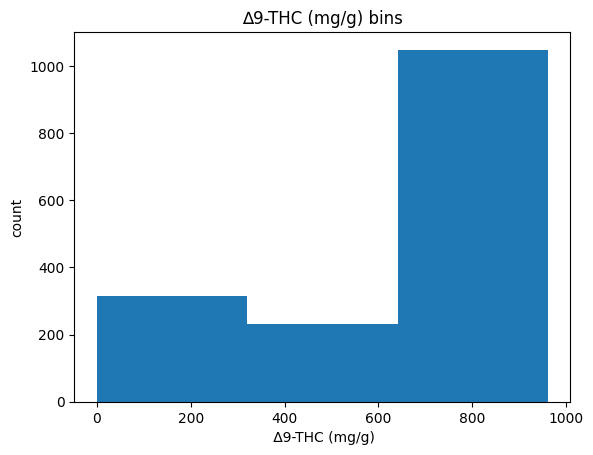

In [27]:
plt.hist(df[" ∆9-THC (mg/g)"], bins = 3)

# set x/y labels and plot title
plt.xlabel(" ∆9-THC (mg/g)")
plt.ylabel("count")
plt.title("∆9-THC (mg/g) bins")

As shown above, samples that test around 800mg/g are very common in our data. <br>
N.B: The df dataframe is a mix of different fractions of samples such as TDT(distillates), THO(heavy oils), TTE(terpenes), TDC(decarboxylated oil), and THT(THC and heavy oil). The goal of this project is to explore any correlations between cannabinoids in and accross these fractions for a start.

In [28]:
df.corr()

/tmp/ipykernel_34/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
∆9-THC (mg/g),1.000000,-0.301001,0.968337,0.968337,-0.183231,-0.181661,-0.182531,-0.131679,0.005377,0.596583,-0.209386,0.174313,0.626314,0.932929
THCA (mg/g),-0.301001,1.000000,-0.053403,-0.053403,-0.007833,-0.000710,-0.002187,-0.031723,-0.003925,-0.224684,0.556868,-0.093342,-0.214097,-0.038385
Total THC (mg/g),0.968337,-0.053403,1.000000,1.000000,-0.193918,-0.190410,-0.191707,-0.146190,0.004602,0.565884,-0.073475,0.158093,0.599788,0.966854
THC Wt.%,0.968337,-0.053403,1.000000,1.000000,-0.193918,-0.190410,-0.191707,-0.146190,0.004602,0.565884,-0.073475,0.158093,0.599788,0.966854
CBD(mg/g),-0.183231,-0.007833,-0.193918,-0.193918,1.000000,0.981800,0.988512,-0.017880,-0.002290,-0.139885,0.132591,-0.049658,-0.089403,-0.094220
CBDA (mg/g),-0.181661,-0.000710,-0.190410,-0.190410,0.981800,1.000000,0.999226,-0.016834,-0.001993,-0.129252,0.145002,-0.049449,-0.094461,-0.088327
Total CBD (mg/g),-0.182531,-0.002187,-0.191707,-0.191707,0.988512,0.999226,1.000000,-0.017101,-0.002060,-0.131842,0.142866,-0.049640,-0.093696,-0.089812
CBNmg/g,-0.131679,-0.031723,-0.146190,-0.146190,-0.017880,-0.016834,-0.017101,1.000000,-0.005289,-0.024382,-0.030781,-0.043921,-0.068766,0.070406
∆8-THCmg/g,0.005377,-0.003925,0.004602,0.004602,-0.002290,-0.001993,-0.002060,-0.005289,1.000000,-0.040637,0.316908,-0.015538,-0.036523,-0.063519
CBGmg/g,0.596583,-0.224684,0.565884,0.565884,-0.139885,-0.129252,-0.131842,-0.024382,-0.040637,1.000000,-0.177178,-0.124450,0.196753,0.595107


### Separation Into Different Sample Types/Fractions (TDT, THO, TTE, TDC, THT)

In [30]:
df_DT =df.loc[df['Sample ID'].str.startswith('RND-DT')].copy()
df_HO =df.loc[df['Sample ID'].str.startswith('RND-HO')].copy()
df_TE =df.loc[df['Sample ID'].str.startswith('RND-TE')].copy()
df_DC =df.loc[df['Sample ID'].str.startswith('RND-DC')].copy()
df_HT =df.loc[df['Sample ID'].str.startswith('RND-HT')].copy()
df_TDT = df.loc[df['Sample ID'].str.startswith('RND-TDT')].copy()
df_TDC = df.loc[df['Sample ID'].str.startswith('RND-TDC')].copy()
df_TTE =df.loc[df['Sample ID'].str.startswith('RND-TTE')].copy()
df_THT = df.loc[df['Sample ID'].str.startswith('RND-THT')].copy()
df_THO = df.loc[df['Sample ID'].str.startswith('RND-THO')].copy()

In [31]:
df_TDTT = pd.concat([df_DT, df_TDT]).drop_duplicates()
df_TDCC = pd.concat([df_DC, df_TDC]).drop_duplicates()
df_TTET = pd.concat([df_TE, df_TTE]).drop_duplicates()
df_THOT = pd.concat([df_HO, df_THO]).drop_duplicates()
df_THTT = pd.concat([df_HT, df_THT]).drop_duplicates()
df_TDT = df_TDTT
df_TDC = df_TDCC
df_TTE = df_TTET
df_THO = df_THOT
df_THT = df_THTT


In [32]:
print("TDT:", df_TDT.shape)
print("TDC:", df_TDC.shape)
print("THO:", df_THO.shape)
print("THT:", df_THT.shape)
print("TTE:", df_TTE.shape)

TDT: (459, 15)
TDC: (173, 15)
THO: (289, 15)
THT: (169, 15)
TTE: (302, 15)


In [33]:
df_TDC.describe()

,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,691.403308,0.353421,691.713258,69.171328,0.706671,4.227401,4.414102,8.772392,0.068566,38.932024,0.313161,3.640086,6.398991,750.617238
std,85.765975,2.516580,84.032797,8.403281,6.501196,39.211643,40.880361,3.724335,0.901844,12.148308,2.967854,6.121620,2.362950,76.574288
min,0.000000,0.000000,18.216800,1.821700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.298900
25%,674.147300,0.000000,674.147300,67.414700,0.000000,0.000000,0.000000,5.869300,0.000000,28.535700,0.000000,0.000000,5.189300,734.700000
50%,695.253200,0.000000,695.253200,69.525300,0.000000,0.000000,0.000000,9.527300,0.000000,42.578500,0.000000,2.668500,6.583700,755.703600
75%,725.482300,0.000000,725.482300,72.548200,0.000000,0.000000,0.000000,11.591800,0.000000,46.446900,0.000000,4.026500,7.467900,784.250000
max,860.970000,23.497800,862.523100,86.252300,62.777200,373.460600,385.954300,16.220400,11.861900,67.590600,37.239200,37.374700,14.427000,904.134300


In [34]:
df_TDT.describe()

,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
count,459.000000,459.000000,459.000000,459.000000,459.000000,459.0,459.000000,459.000000,459.0,459.000000,459.0,459.000000,459.000000,459.000000
mean,823.106492,0.303393,823.372568,82.337256,0.056331,0.0,0.056331,27.232802,0.0,39.448577,0.0,4.604418,7.542147,902.294216
std,147.036906,2.938935,146.936354,14.693633,0.374955,0.0,0.374955,108.218572,0.0,16.792110,0.0,6.029381,2.860858,85.770823
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,21.370000
25%,829.505950,0.000000,829.662000,82.966200,0.000000,0.0,0.000000,6.255100,0.0,25.201000,0.0,0.000000,6.532300,894.790550
50%,853.510300,0.000000,853.510300,85.351000,0.000000,0.0,0.000000,9.728400,0.0,42.355500,0.0,3.975700,7.759900,919.007100
75%,875.548700,0.000000,875.548700,87.554900,0.000000,0.0,0.000000,13.447900,0.0,53.915850,0.0,5.779300,8.927000,936.528000
max,961.410400,41.136200,961.410400,96.141000,4.949000,0.0,4.949000,881.860700,0.0,71.550500,0.0,43.365400,16.922400,998.592600


In [35]:
df_THT.describe()

,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
count,169.000000,169.0,169.000000,169.000000,169.0,169.0,169.0,169.000000,169.0,169.000000,169.0,169.000000,169.000000,169.000000
mean,772.000604,0.0,772.000604,77.200059,0.0,0.0,0.0,7.920393,0.0,36.715918,0.0,3.305579,6.517479,826.460001
std,58.113631,0.0,58.113631,5.811363,0.0,0.0,0.0,4.106243,0.0,13.540490,0.0,4.642569,2.252495,54.494207
min,569.627800,0.0,569.627800,56.962800,0.0,0.0,0.0,0.000000,0.0,14.753300,0.0,0.000000,0.000000,594.373700
25%,730.758600,0.0,730.758600,73.075900,0.0,0.0,0.0,4.822700,0.0,25.311700,0.0,0.000000,5.525200,796.190000
50%,776.008300,0.0,776.008300,77.600800,0.0,0.0,0.0,7.234000,0.0,32.996200,0.0,2.229300,6.460000,827.492700
75%,811.659700,0.0,811.659700,81.166000,0.0,0.0,0.0,10.324100,0.0,47.540800,0.0,4.943000,7.804400,854.154900
max,918.804600,0.0,918.804600,91.880500,0.0,0.0,0.0,24.698700,0.0,71.243000,0.0,24.289200,13.155700,970.670000


In [36]:
df_THO.describe()

,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
count,289.000000,289.0,289.000000,289.000000,289.0,289.0,289.0,289.000000,289.0,289.000000,289.0,289.000000,289.000000,289.000000
mean,471.952609,0.0,471.952609,47.195261,0.0,0.0,0.0,7.563888,0.0,36.336541,0.0,0.209620,1.179507,517.242147
std,239.136619,0.0,239.136619,23.913664,0.0,0.0,0.0,4.493564,0.0,20.642476,0.0,1.237893,1.969271,258.007159
min,33.888700,0.0,33.888700,3.388900,0.0,0.0,0.0,0.000000,0.0,6.152700,0.0,0.000000,0.000000,43.380000
25%,244.143100,0.0,244.143100,24.414300,0.0,0.0,0.0,4.351600,0.0,21.835600,0.0,0.000000,0.000000,272.695700
50%,428.804700,0.0,428.804700,42.880500,0.0,0.0,0.0,6.479400,0.0,29.984300,0.0,0.000000,0.000000,460.873200
75%,731.073300,0.0,731.073300,73.107300,0.0,0.0,0.0,9.834100,0.0,43.761100,0.0,0.000000,2.557900,794.873400
max,880.314900,0.0,880.314900,88.031500,0.0,0.0,0.0,23.579200,0.0,102.325200,0.0,14.064100,9.485900,967.582100


In [37]:
df_TTE.describe()

,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.0,302.000000,302.000000,302.000000,302.000000,302.000000
mean,394.255801,19.568186,411.417100,41.141714,0.069586,0.004137,0.073215,3.792924,0.0,13.408203,1.387127,7.445780,6.249936,446.181556
std,235.211718,84.554513,226.286616,22.628662,0.398712,0.063916,0.402003,3.185717,0.0,10.942862,4.948674,8.908238,4.283089,245.534131
min,0.000000,0.000000,40.652700,4.065300,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,40.652700
25%,191.209925,0.000000,209.894600,20.989450,0.000000,0.000000,0.000000,0.687700,0.0,5.720950,0.000000,2.256575,3.210350,227.955000
50%,380.430800,0.000000,395.933300,39.593350,0.000000,0.000000,0.000000,3.626600,0.0,10.855350,0.000000,5.974950,5.693750,423.657400
75%,608.488975,0.000000,624.804200,62.480450,0.000000,0.000000,0.000000,6.005325,0.0,18.942575,0.000000,9.413825,9.169450,678.742500
max,897.931200,560.963800,897.931200,89.793100,3.912000,1.101300,3.912000,20.415500,0.0,50.141800,36.792100,60.648800,18.223600,951.420000


In [38]:
#TTE_THT_Ratio = df_TTE[[' ∆9-THC (mg/g)','CBGmg/g','CBNmg/g']]/df_THT[[' ∆9-THC (mg/g)','CBGmg/g','CBNmg/g']]

In [39]:
#TTE_THT_Ratio.replace(np.nan, 0 , inplace=True)

In [40]:
#TTE_THT_Ratio.shape

In [41]:
#THO_TDT_Ratio = df_THO[[' ∆9-THC (mg/g)','CBGmg/g', 'CBNmg/g','CBCmg/g']]/df_TDT[[' ∆9-THC (mg/g)','CBGmg/g','CBNmg/g','CBCmg/g']]

In [42]:
#THO_TDT_Ratio.replace(np.nan, 0 , inplace=True)

In [43]:
#THO_TDT_Ratio.shape

In [44]:
#TTE_THT_Ratio = TTE_THT_Ratio[(TTE_THT_Ratio[[' ∆9-THC (mg/g)','CBGmg/g', 'CBNmg/g']] !=0).all(axis=1)]


In [45]:
#TTE_THT_Ratio.shape

### Remove rows of the selected columns that have 0

In [105]:
#THO_TDT_Ratio = THO_TDT_Ratio[(THO_TDT_Ratio[[' ∆9-THC (mg/g)','CBGmg/g', 'CBNmg/g']] !=0).all(axis=1)]


In [106]:
#THO_TDT_Ratio.shape

In [107]:
#TTE_THT_Ratio.head(10)

In [108]:
#THO_TDT_Ratio.corr()

In [46]:
#TTE_THT_Ratio.corr()

### Heatmap Plot of Distillate Samples showing d9-THC, CBN, and CBG
Visualize any relationship between these three cannabinoids in distillates.

In [49]:
df_columns = df[[' ∆9-THC (mg/g)', 'CBGmg/g','CBNmg/g']]

In [50]:
df_TDT_Heat = df_TDT[['Sample ID',' ∆9-THC (mg/g)', 'CBGmg/g','CBNmg/g']]
df_TDT_Heat.set_index('Sample ID', inplace=True)
df_TDT_Heat.head()

,∆9-THC (mg/g),CBGmg/g,CBNmg/g
Sample ID,,,
RND-DT-201215-01,905.4981,0.0,0.0
RND-DT-201214-01,915.9416,0.0,0.0
RND-DT-201211-03,926.4238,0.0,0.0
RND-DT-210111-01,909.8991,0.0,0.0
RND-DT-210111-02,893.6987,0.0,0.0


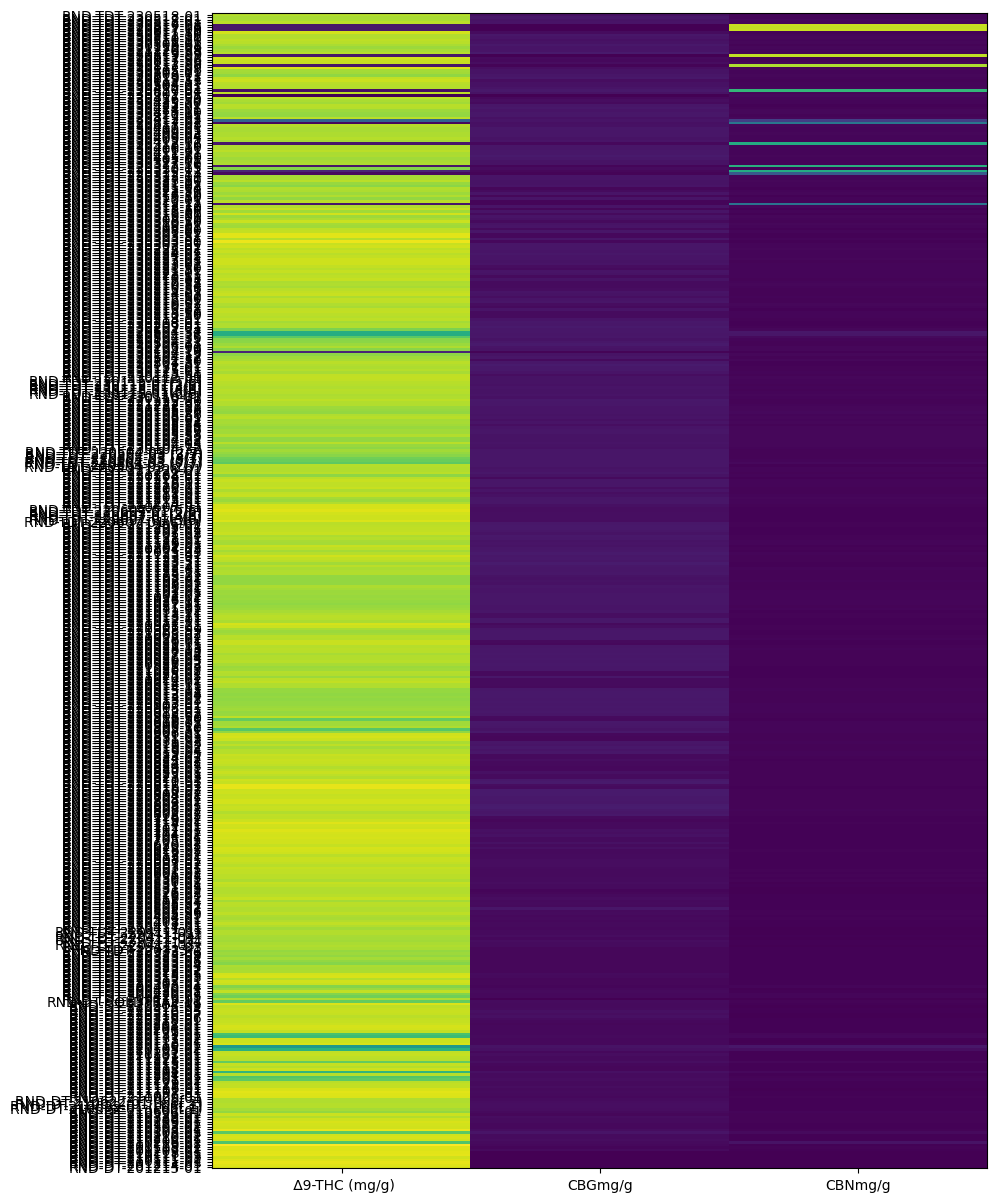

In [51]:
index = df_TDT_Heat
columns = df_columns
plt.figure(figsize=(10,15))
plt.pcolor(df_TDT_Heat)
plt.yticks(np.arange(0.5, len(df_TDT_Heat.index), 1), df_TDT_Heat.index)
plt.xticks(np.arange(0.5, len(df_TDT_Heat.columns), 1), df_TDT_Heat.columns)
plt.show()

<AxesSubplot: ylabel='Sample ID'>

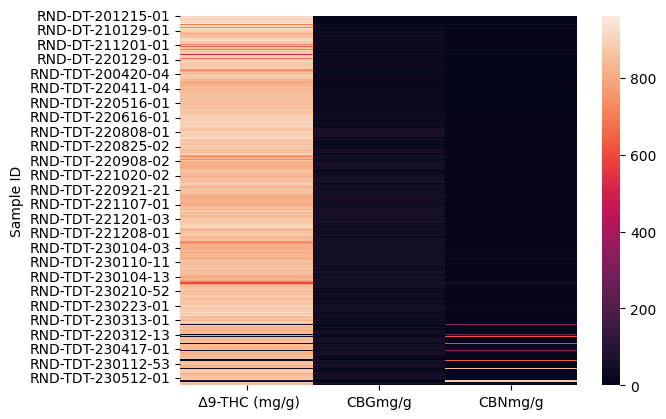

In [527]:
sns.heatmap(df_TDT_Heat)

### Sub-plots Visualizing the relationships between THC vs CBG, CBN and CBC for TDT and TDC Samples

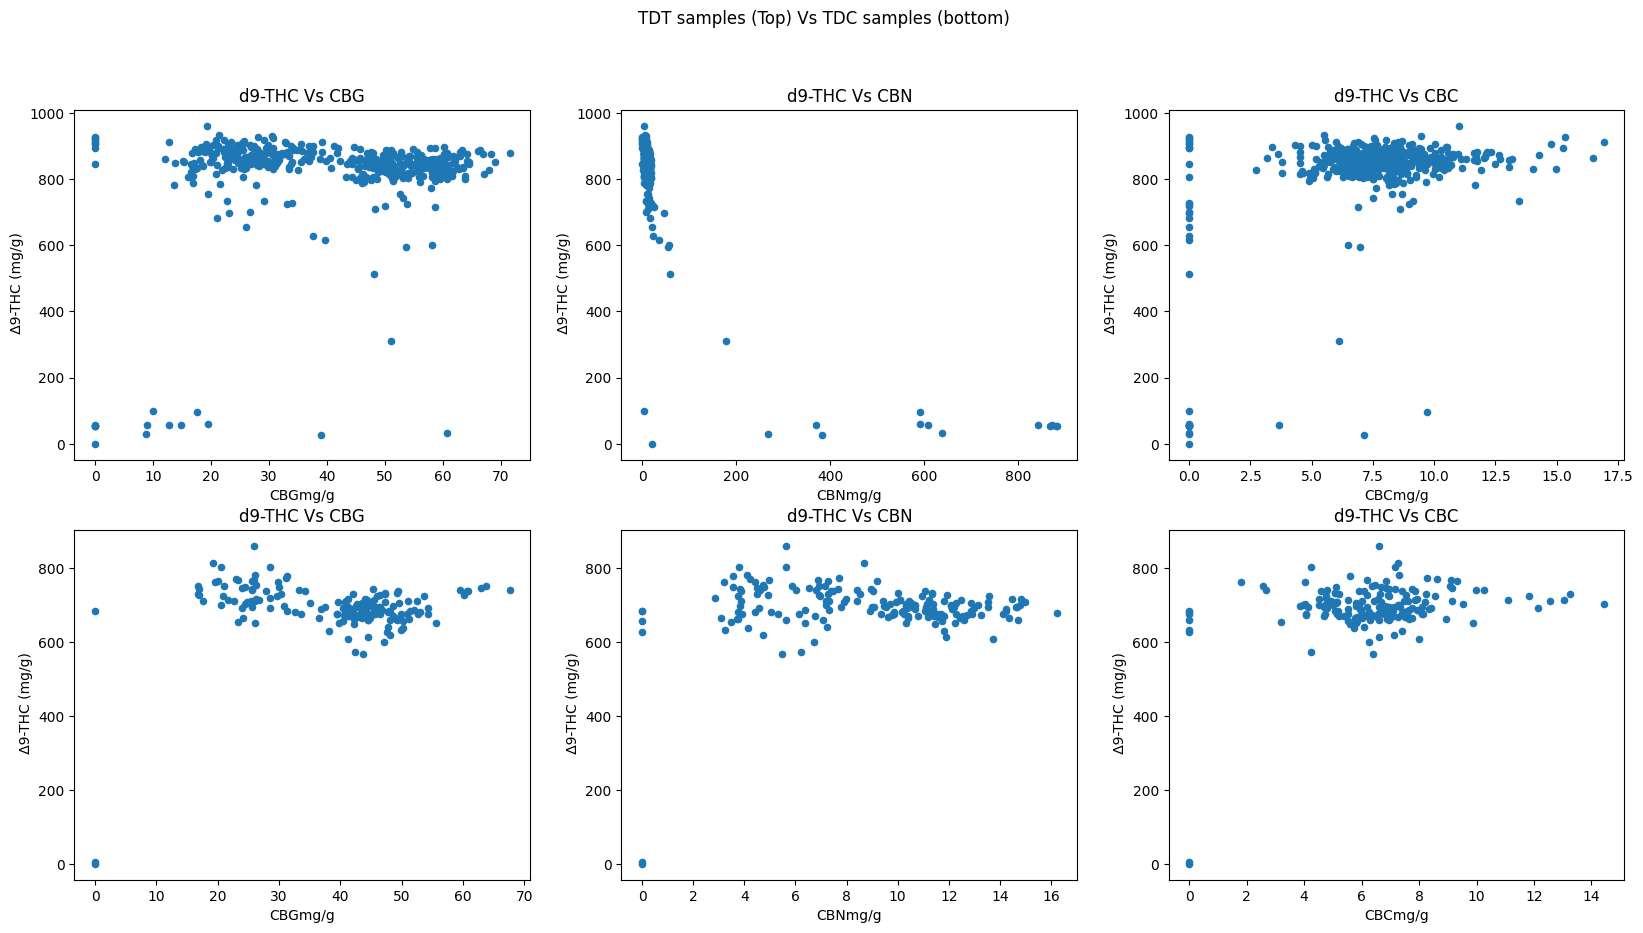

In [52]:
fig = plt.figure()

ax0 = fig.add_subplot(2,3,1)
ax1 = fig.add_subplot(2,3,2)
ax2 = fig.add_subplot(2,3,3)
ax3 = fig.add_subplot(2,3,4)
ax4 = fig.add_subplot(2,3,5)
ax5 = fig.add_subplot(2,3,6)

#subplot 1 
df_TDT.plot(kind='scatter', x='CBGmg/g', y=' ∆9-THC (mg/g)', figsize=(20,10), ax=ax0)
ax0.set_title('d9-THC Vs CBG')
ax0.set_xlabel('CBGmg/g')
ax0.set_ylabel(' ∆9-THC (mg/g)')

#subplot 2
df_TDT.plot(kind='scatter',x='CBNmg/g', y=' ∆9-THC (mg/g)', figsize=(20,10), ax=ax1)
ax1.set_title('d9-THC Vs CBN')
ax1.set_xlabel('CBNmg/g')
ax1.set_ylabel(' ∆9-THC (mg/g)')

#subplot 3
df_TDT.plot(kind='scatter', x='CBCmg/g', y=' ∆9-THC (mg/g)', figsize=(20,10), ax=ax2)
ax2.set_title('d9-THC Vs CBC')
ax2.set_xlabel('CBCmg/g')
ax2.set_ylabel(' ∆9-THC (mg/g)')

#subplot 4
df_TDC.plot(kind='scatter', x='CBGmg/g', y=' ∆9-THC (mg/g)', figsize=(20,10), ax=ax3)
ax3.set_title('d9-THC Vs CBG')
ax3.set_xlabel('CBGmg/g')
ax3.set_ylabel(' ∆9-THC (mg/g)')

#subplot 2
df_TDC.plot(kind='scatter',x='CBNmg/g', y=' ∆9-THC (mg/g)', figsize=(20,10), ax=ax4)
ax4.set_title('d9-THC Vs CBN')
ax4.set_xlabel('CBNmg/g')
ax4.set_ylabel(' ∆9-THC (mg/g)')

#subplot 3
df_TDC.plot(kind='scatter', x='CBCmg/g', y=' ∆9-THC (mg/g)', figsize=(20,10), ax=ax5)
ax5.set_title('d9-THC Vs CBC')
ax5.set_xlabel('CBCmg/g')
ax5.set_ylabel(' ∆9-THC (mg/g)')

plt.suptitle('TDT samples (Top) Vs TDC samples (bottom)')
plt.show()

### Normalization
To see if any relationship exists between cannabinoids ratio across fractions.

In [53]:
df['CBG_THC_Ratio'] = df['CBGmg/g']/df[' ∆9-THC (mg/g)']
df['CBN_THC_Ratio'] = df['CBNmg/g']/df[' ∆9-THC (mg/g)']
df['CBC_THC_Ratio'] = df['CBCmg/g']/df[' ∆9-THC (mg/g)']
df['THC_Total_Ratio'] = df[' ∆9-THC (mg/g)']/df['Total']

In [54]:
df.head()

,Sample ID,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total,CBG_THC_Ratio,CBN_THC_Ratio,CBC_THC_Ratio,THC_Total_Ratio
Date of Analysis,,,,,,,,,,,,,,,,,,,
2021-01-13,RND-DT-201215-01,905.4981,0.0,905.4981,90.5498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905.4981,0.0,0.0,0.0,1.0
2021-01-13,RND-DT-201214-01,915.9416,0.0,915.9416,91.5942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,915.9416,0.0,0.0,0.0,1.0
2021-01-13,RND-DT-201211-03,926.4238,0.0,926.4238,92.6424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926.4238,0.0,0.0,0.0,1.0
2021-01-13,RND-DT-210111-01,909.8991,0.0,909.8991,90.9899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,909.8991,0.0,0.0,0.0,1.0
2021-01-13,RND-DT-210111-02,893.6987,0.0,893.6987,89.3699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,893.6987,0.0,0.0,0.0,1.0


In [531]:
df.corr()

/tmp/ipykernel_34/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total,CBG_THC_Ratio,CBN_THC_Ratio,CBC_THC_Ratio,THC_Total_Ratio
∆9-THC (mg/g),1.000000,-0.301001,0.968337,0.968337,-0.183231,-0.181661,-0.182531,-0.131679,0.005377,0.596583,-0.209386,0.174313,0.626314,0.932929,-0.131896,-0.190197,-0.063227,0.051436
THCA (mg/g),-0.301001,1.000000,-0.053403,-0.053403,-0.007833,-0.000710,-0.002187,-0.031723,-0.003925,-0.224684,0.556868,-0.093342,-0.214097,-0.038385,-0.053618,-0.014308,-0.066957,-0.053162
Total THC (mg/g),0.968337,-0.053403,1.000000,1.000000,-0.193918,-0.190410,-0.191707,-0.146190,0.004602,0.565884,-0.073475,0.158093,0.599788,0.966854,-0.152408,-0.203273,-0.083865,0.039944
THC Wt.%,0.968337,-0.053403,1.000000,1.000000,-0.193918,-0.190410,-0.191707,-0.146190,0.004602,0.565884,-0.073475,0.158093,0.599788,0.966854,-0.152408,-0.203273,-0.083865,0.039944
CBD(mg/g),-0.183231,-0.007833,-0.193918,-0.193918,1.000000,0.981800,0.988512,-0.017880,-0.002290,-0.139885,0.132591,-0.049658,-0.089403,-0.094220,-0.033821,-0.004243,0.798713,-0.032941
CBDA (mg/g),-0.181661,-0.000710,-0.190410,-0.190410,0.981800,1.000000,0.999226,-0.016834,-0.001993,-0.129252,0.145002,-0.049449,-0.094461,-0.088327,-0.029301,-0.003378,0.727716,-0.031849
Total CBD (mg/g),-0.182531,-0.002187,-0.191707,-0.191707,0.988512,0.999226,1.000000,-0.017101,-0.002060,-0.131842,0.142866,-0.049640,-0.093696,-0.089812,-0.030363,-0.003574,0.745190,-0.032170
CBNmg/g,-0.131679,-0.031723,-0.146190,-0.146190,-0.017880,-0.016834,-0.017101,1.000000,-0.005289,-0.024382,-0.030781,-0.043921,-0.068766,0.070406,0.347155,0.961997,0.053431,-0.032121
∆8-THCmg/g,0.005377,-0.003925,0.004602,0.004602,-0.002290,-0.001993,-0.002060,-0.005289,1.000000,-0.040637,0.316908,-0.015538,-0.036523,-0.063519,-0.021180,-0.002398,-0.011938,0.996441
CBGmg/g,0.596583,-0.224684,0.565884,0.565884,-0.139885,-0.129252,-0.131842,-0.024382,-0.040637,1.000000,-0.177178,-0.124450,0.196753,0.595107,0.307462,-0.069588,-0.097823,-0.015672


### Examining the relationships between cannabinoids in each fraction

In [55]:
df_TDT[[' ∆9-THC (mg/g)', 'CBGmg/g','CBNmg/g','CBCmg/g','Total']].corr()

,∆9-THC (mg/g),CBGmg/g,CBNmg/g,CBCmg/g,Total
∆9-THC (mg/g),1.000000,0.172172,-0.833265,0.427040,0.719131
CBGmg/g,0.172172,1.000000,-0.224462,0.040980,0.198342
CBNmg/g,-0.833265,-0.224462,1.000000,-0.348018,-0.231190
CBCmg/g,0.427040,0.040980,-0.348018,1.000000,0.365776
Total,0.719131,0.198342,-0.231190,0.365776,1.000000


In [56]:
df_TDC[[' ∆9-THC (mg/g)', 'CBGmg/g','CBNmg/g','CBCmg/g','Total']].corr()

,∆9-THC (mg/g),CBGmg/g,CBNmg/g,CBCmg/g,Total
∆9-THC (mg/g),1.000000,0.130579,0.130706,0.328603,0.614289
CBGmg/g,0.130579,1.000000,0.286852,0.006903,0.238871
CBNmg/g,0.130706,0.286852,1.000000,0.239397,0.218873
CBCmg/g,0.328603,0.006903,0.239397,1.000000,0.406239
Total,0.614289,0.238871,0.218873,0.406239,1.000000


In [534]:
df_THO[[' ∆9-THC (mg/g)', 'CBGmg/g','CBNmg/g','CBCmg/g','Total']].corr()

,∆9-THC (mg/g),CBGmg/g,CBNmg/g,CBCmg/g,Total
∆9-THC (mg/g),1.000000,0.711285,0.516908,0.615511,0.997958
CBGmg/g,0.711285,1.000000,0.632691,0.382577,0.752863
CBNmg/g,0.516908,0.632691,1.000000,0.514551,0.551515
CBCmg/g,0.615511,0.382577,0.514551,1.000000,0.619147
Total,0.997958,0.752863,0.551515,0.619147,1.000000


In [535]:
df_TTE[[' ∆9-THC (mg/g)', 'CBGmg/g','CBNmg/g','CBCmg/g','Total']].corr()

,∆9-THC (mg/g),CBGmg/g,CBNmg/g,CBCmg/g,Total
∆9-THC (mg/g),1.000000,0.823745,0.669456,0.774696,0.939531
CBGmg/g,0.823745,1.000000,0.697090,0.531179,0.798029
CBNmg/g,0.669456,0.697090,1.000000,0.583840,0.640564
CBCmg/g,0.774696,0.531179,0.583840,1.000000,0.705907
Total,0.939531,0.798029,0.640564,0.705907,1.000000


In [536]:
df_THT[[' ∆9-THC (mg/g)', 'CBGmg/g','CBNmg/g','CBCmg/g','Total']].corr()

,∆9-THC (mg/g),CBGmg/g,CBNmg/g,CBCmg/g,Total
∆9-THC (mg/g),1.000000,-0.347534,-0.371176,0.203520,0.960271
CBGmg/g,-0.347534,1.000000,0.344373,-0.042054,-0.113393
CBNmg/g,-0.371176,0.344373,1.000000,0.220860,-0.202960
CBCmg/g,0.203520,-0.042054,0.220860,1.000000,0.308109
Total,0.960271,-0.113393,-0.202960,0.308109,1.000000


### Potential Candidates

Distillate df_TDT: CBN, and CBC vs THC<br>
Heavy oil df_THO: CBN, CBG, CBC vs THC<br>
Terpene df_TTE: CBN, CBG, CBC vs THC<br>
Heavy+Terpenes df_THT: CBG, CBC vs THC<br>

Next we visualize the correlation coefficients that are over 0.60 to see any obvious relationship. The regplot and residplot codes below are used to visualize the relationship between the cannabinoids in each fraction

<AxesSubplot: xlabel='CBGmg/g', ylabel=' ∆9-THC (mg/g)'>

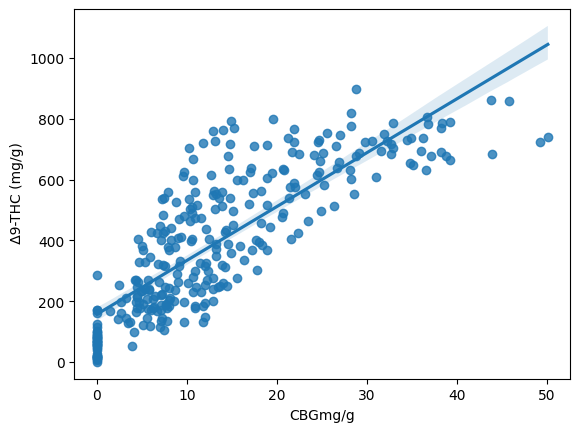

In [116]:
sns.regplot(x='CBGmg/g', y=' ∆9-THC (mg/g)', data=df_TTE)

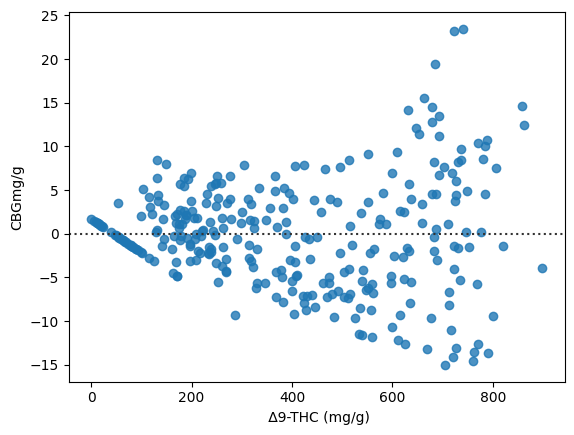

In [117]:
sns.residplot(x=df_TTE[' ∆9-THC (mg/g)'],y=df_TTE['CBGmg/g'])
plt.show()

The Function below is used to test the regression fit (either linear or polynomial) between suspected cannabinoids in each fraction. The cannabinoids were suspected to be correlated based on the value of the correlation coefficient shown in the dataframes above for each oil fraction.

In [57]:
def PlotPolly(model, independent_variable, dependent_variable, Name):
    x_new = np.linspace(15, 55, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variable, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit with Matplotlib for variables')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('THC')

    plt.show()
    plt.close()

In [58]:
x = df_TDT['CBGmg/g']
y = df_TDT[' ∆9-THC (mg/g)']

In [59]:
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)

          3          2
0.004603 x - 0.6246 x + 26.28 x + 504


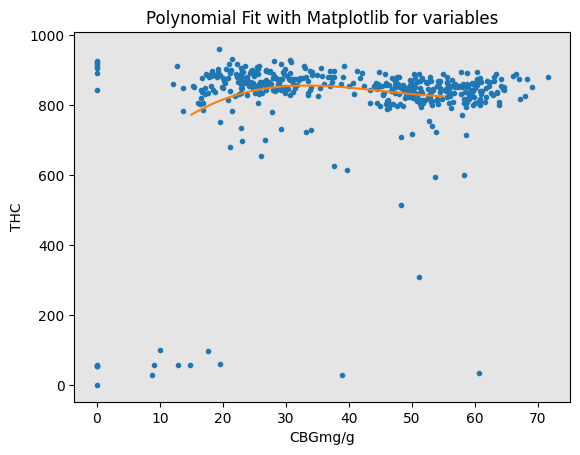

In [60]:
PlotPolly(p, x, y, 'CBGmg/g')

## Deductions from the plots
### Distillate TDT
 CBC vs THC: ploynomial<br>
 CBN vs THC: Linear(negative)<br>
 Total vs THC: Linear

### Decarbed oil TDC
 CBC vs THC: polynomial<br>
 Total vs THC: Linear

### Heavy oil THO
 Total vs THC: Linear<br>
 CBG vs THC: Linear<br>
 CBN vs THC: polynomial(5th order)<br>
 CBC vs THC: polynomial

### Terpene fraction TTE
 CBG vs THC: Linear<br>
 CBN vs THC: polynomial (5th order)<br>
 CBC vs THC: polynomial<br>
 Total vs THC: Linear

### Heavy+Terpene fraction THT
 CBG vs THC: Linear<br>
 CBC vs THC: polynomial (4th order)<br>
 Total vs THC: Linear

## CBN vs THC for Distillates
The primary objective of this study is to delve into the well-documented relationship between Cannabinol (CBN) and delta-9-tetrahydrocannabinol (THC). This relationship serves as a cornerstone in addressing the pressing issue of THC inflation within the cannabis industry. Additionally, the study aims to develop a robust predictive model that not only explores the CBN-THC dynamics but also instills a high degree of confidence in the reported THC values for cannabis distillates. This model's core function is to mitigate the impact of inflated THC data, which can be inadvertently generated by testing laboratories, and thereby foster greater transparency and accuracy in the industry

In [66]:
df_TDT = df_TDT.dropna()
df_TDT = df_TDT.reset_index()

In [67]:
df_TDT.head(3)

,index,Date of Analysis,Sample ID,∆9-THC (mg/g),THCA (mg/g),Total THC (mg/g),THC Wt.%,CBD(mg/g),CBDA (mg/g),Total CBD (mg/g),CBNmg/g,∆8-THCmg/g,CBGmg/g,CBGAmg/g,THCVmg/g,CBCmg/g,Total
0,0,2021-01-13,RND-DT-201215-01,905.4981,0.0,905.4981,90.5498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905.4981
1,1,2021-01-13,RND-DT-201214-01,915.9416,0.0,915.9416,91.5942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,915.9416
2,2,2021-01-13,RND-DT-201211-03,926.4238,0.0,926.4238,92.6424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926.4238


In [68]:
df_TDT.shape

(459, 17)

In [69]:
X = df_TDT[['CBNmg/g']]
Y = df_TDT[' ∆9-THC (mg/g)']


In [70]:
# Pearson Correlation Coefficient
pearson_coef, p_value = stats.pearsonr(df_TDT['CBNmg/g'], df_TDT[' ∆9-THC (mg/g)'])
print( "The Pearson Correlation Coefficient is", round(pearson_coef,3), " with a P-value of P = ", p_value) 

The Pearson Correlation Coefficient is -0.833  with a P-value of P =  1.0732005002328774e-119


### Predictive Analysis

In [71]:
lm = LinearRegression()
lm.fit(X,Y)
Yhat=lm.predict(X)
Yhat[0:5] 

array([853.93837047, 853.93837047, 853.93837047, 853.93837047,
       853.93837047])

A RobustScaler was chosen over the StandardScaler to minimize the effect of outliers on the model.<br>
The PolynomialFeatures was also applied to avoid overfitting or underfitting of the linear points, and ensure the optimal points are used for the linear regression for better predictive model.

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures

Input = [("scale", RobustScaler()), ('polynomial', PolynomialFeatures(degree=3,include_bias=False)),  ("model", LinearRegression())]

pipe = Pipeline(Input)
pipe

Pipeline(steps=[('scale', RobustScaler()),
                ('polynomial',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('model', LinearRegression())])

In [73]:
pipe.fit(X, Y)

ypipe=pipe.predict(X)
ypipe[0:5]

array([897.74893521, 897.74893521, 897.74893521, 897.74893521,
       897.74893521])

In [74]:
print("Slope:", lm.coef_)
print("Intercept:", lm.intercept_)

Slope: [-1.1321596]
Intercept: 853.938370472277


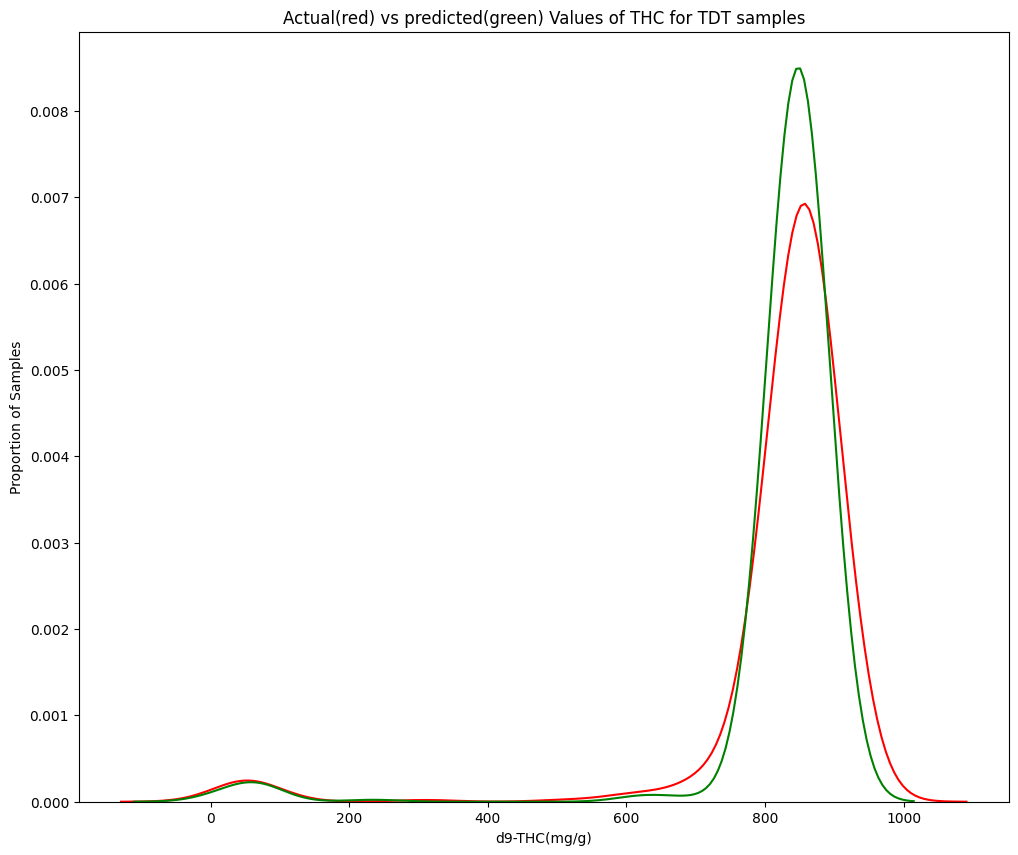

In [75]:
plt.figure(figsize=(12, 10))


ax1 = sns.kdeplot(Y, color="r")
sns.kdeplot(ypipe, color="g", ax=ax1)


plt.title('Actual(red) vs predicted(green) Values of THC for TDT samples')
plt.xlabel('d9-THC(mg/g)')
plt.ylabel('Proportion of Samples')

plt.show()
plt.close()

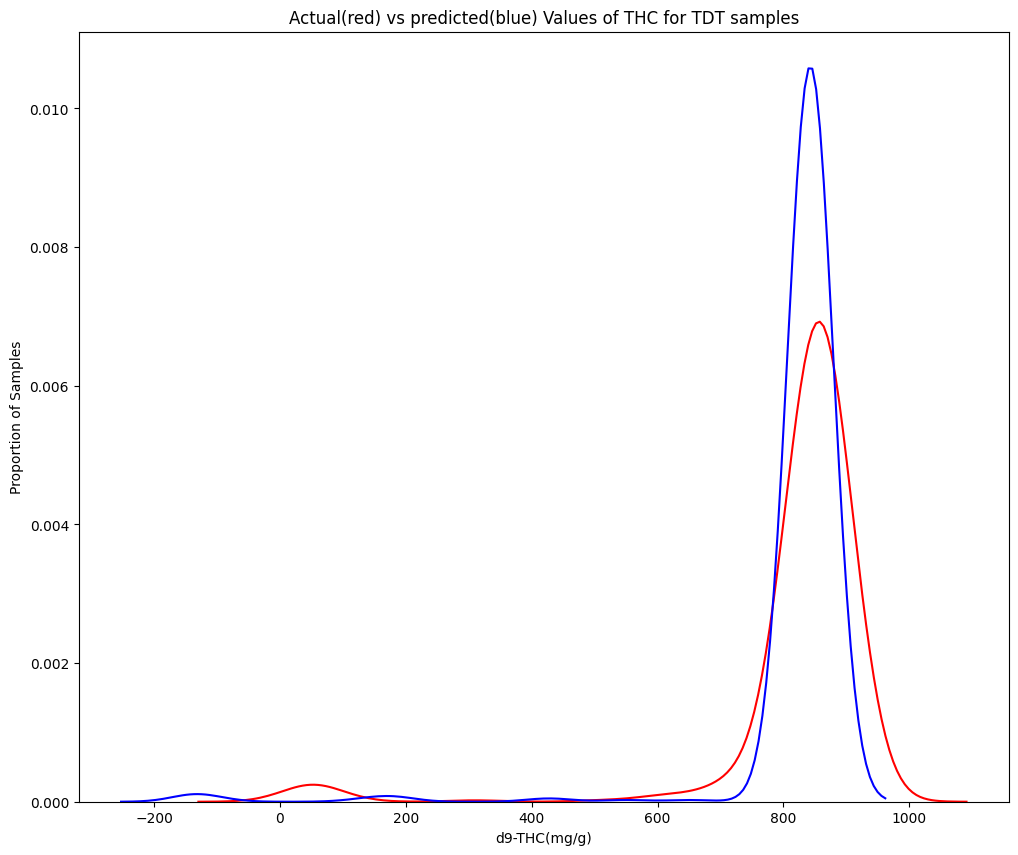

In [76]:
plt.figure(figsize=(12, 10))


ax1 = sns.kdeplot(Y, color="r")
sns.kdeplot(Yhat, color="b", ax=ax1)


plt.title('Actual(red) vs predicted(blue) Values of THC for TDT samples')
plt.xlabel('d9-THC(mg/g)')
plt.ylabel('Proportion of Samples')

plt.show()
plt.close()

As one could see above from the KDE plots, the model performs better using the pipeline (having the robustscaler and polynomial features) than just using only the linear regression (Yhat).

## CBG vs THC in Heavy oils (THO)

In [553]:
#df_THO = df_THO.dropna()
#df_THO = df_THO.reset_index()

In [554]:
#pearson_coef, p_value = stats.pearsonr(df_THO['CBGmg/g'], df_THO[' ∆9-THC (mg/g)'])
#print( "The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P = ", p_value ) 

The Pearson Correlation Coefficient is 0.7112849969559375  with a P-value of P =  7.554922321317211e-46


In [555]:
#X1 = df_THO[['CBGmg/g']]
#Y1 = df_THO[' ∆9-THC (mg/g)']
#lm2 = LinearRegression()
#lm2.fit(X1,Y1)
#Yhat_1=lm2.predict(X1)
#Yhat_1[0:10] 

array([356.59125463, 343.11965594, 340.91710024, 252.4745593 ,
       449.61936329, 473.95954028, 398.92844593, 440.52650798,
       252.76543179, 342.4415028 ])

In [79]:
#Input2 = [("scale", RobustScaler()), ('polynomial', PolynomialFeatures(degree=8,include_bias=False)),  ("model", LinearRegression())]

#pipe2 = Pipeline(Input2)
#pipe2

#pipe2.fit(X1, Y1)

#ypipe2=pipe2.predict(X1)
#ypipe2[0:10]

In [77]:
#plt.figure(figsize=(12, 10))


#ax1 = sns.kdeplot(Y1, color="r")
#sns.kdeplot(ypipe2, color="g", ax=ax1)


#plt.title('Actual vs predicted(green) Values of THC in THO samples')
#plt.xlabel('d9-THC(mg/g)')
#plt.ylabel('Proportion of Samples')

#plt.show()
#plt.close()

## CBG VS THC In Terpenes Fraction(TTE)

In [78]:
#df_TTE = df_TTE.dropna()
#df_TTE = df_TTE.reset_index()
#X2 = df_TTE[['CBGmg/g']]
#Y2 = df_TTE[' ∆9-THC (mg/g)']
#lm3 = LinearRegression()
#lm3.fit(X2,Y2)
#Yhat_2=lm3.predict(X2)
#Yhat_2[0:10] 

In [80]:
#Input3 = [("scale", RobustScaler()), ('polynomial', PolynomialFeatures(degree=3,include_bias=False)),  ("model", LinearRegression())]

#pipe3 = Pipeline(Input3)
#pipe3

#pipe3.fit(X2, Y2)

#ypipe3=pipe3.predict(X2)
#ypipe3[0:10]

In [560]:
#pearson_coef, p_value = stats.pearsonr(df_TTE['CBGmg/g'], df_TTE[' ∆9-THC (mg/g)'])
#print( "The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P = ", p_value ) 

The Pearson Correlation Coefficient is 0.8237453868179266  with a P-value of P =  6.490091097566284e-76


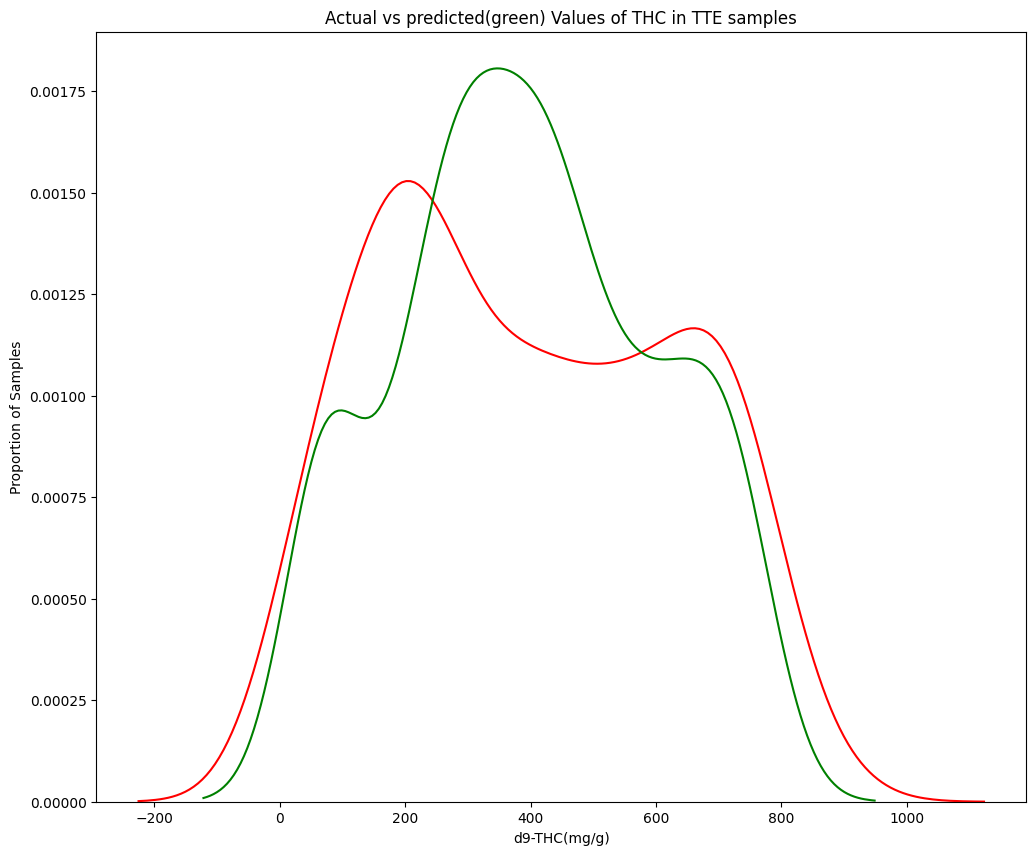

In [561]:
#plt.figure(figsize=(12, 10))


#ax1 = sns.kdeplot(Y2, color="r")
#sns.kdeplot(ypipe3, color="g", ax=ax1)


#plt.title('Actual vs predicted(green) Values of THC in TTE samples')
#plt.xlabel('d9-THC(mg/g)')
#plt.ylabel('Proportion of Samples')

#plt.show()
#plt.close()

### Multi-linear Regression Relationships for any type/fraction of sample (all dataset)

Three independent variables - CBN, CBG,and CBC were used to predict the d9-THC values.

In [87]:
df = df.dropna()
df = df.reset_index()

In [88]:
lm1 = LinearRegression()
Z = df[['CBNmg/g','CBGmg/g', 'CBCmg/g']]
lm1.fit(Z, df[' ∆9-THC (mg/g)'])

LinearRegression()

In [89]:
Yhat1=lm1.predict(Z)
Yhat1[0:10] 

array([224.61139795, 224.61139795, 224.61139795, 224.61139795,
       224.61139795, 224.61139795, 224.61139795, 224.61139795,
       224.61139795, 224.61139795])

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures

Input1 = [("scale", RobustScaler()), ('polynomial', PolynomialFeatures(degree=6,include_bias=False)),  ("model", LinearRegression())]

pipe1 = Pipeline(Input1)
pipe1

Pipeline(steps=[('scale', RobustScaler()),
                ('polynomial',
                 PolynomialFeatures(degree=6, include_bias=False)),
                ('model', LinearRegression())])

In [91]:
pipe1.fit(Z, df[' ∆9-THC (mg/g)'])

ypipe1=pipe1.predict(Z)
ypipe1[0:5]

array([204.43523677, 204.43523677, 204.43523677, 204.43523677,
       204.43523677])

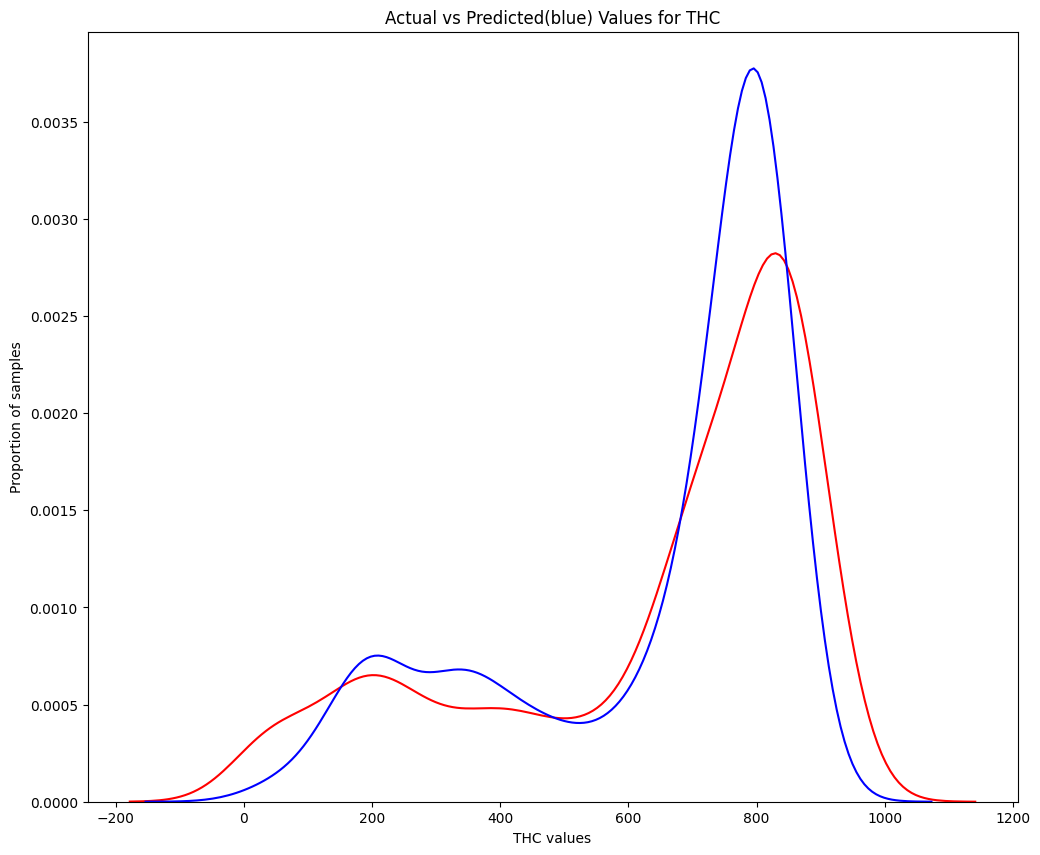

In [94]:
plt.figure(figsize=(12, 10))


ax1 = sns.kdeplot(df[' ∆9-THC (mg/g)'], color="r")
sns.kdeplot(ypipe1, color="b", ax=ax1)


plt.title('Actual vs Predicted(blue) Values for THC')
plt.xlabel('THC values')
plt.ylabel('Proportion of samples')

plt.show()
plt.close()

# Model Evaluation

### R-squared(r2) and Mean Square Error (MSE)

#### r2 and MSE of CBN vs THC in distillates (TDT)

In [568]:
lm.fit(X, Y)
print('The R-square is: ', lm.score(X, Y))

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y, Yhat)
print('The mean square error is: ', mse)


The R-square is:  0.6943304113508832
The mean square error is:  6594.133498954729


In [569]:
lm.fit(X, ypipe)
print('The R-square is: ', lm.score(X, ypipe))

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y, ypipe)
print('The mean square error is: ', mse)

The R-square is:  0.8508493915142892
The mean square error is:  3968.4400103786465


####  r2 and mse for Multi-linear Regression Relationship for any type of sample

In [572]:
Yhat1=lm1.predict(Z)
print('The R-square is: ', lm1.score(Z, df[' ∆9-THC (mg/g)']))

mse = mean_squared_error(df[' ∆9-THC (mg/g)'], Yhat1)
print('The mean square error is: ', mse)

The R-square is:  0.6030399160620126
The mean square error is:  27048.273358430302


## Training and Testing

#### Training and testing for all types of samples(Z)

In [95]:
y_data = df[' ∆9-THC (mg/g)']

In [96]:
x_data = df.drop(' ∆9-THC (mg/g)', axis=1)

In [97]:
x_data.shape

(1564, 20)

In [107]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 470
number of training samples: 1094


### Ridge Regression of multilinear relationship

In [108]:
pr=PolynomialFeatures(degree=4)
x_train_pr=pr.fit_transform(x_train[['CBNmg/g','CBGmg/g', 'CBCmg/g']])
x_test_pr=pr.fit_transform(x_test[['CBNmg/g','CBGmg/g', 'CBCmg/g']])

In [109]:
from sklearn.linear_model import Ridge
RidgeModel=Ridge(alpha=10)
RidgeModel.fit(x_train_pr, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.99257e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=10)

In [110]:
RidgeModel.score(x_test_pr, y_test)


-63.113220861748076

In [115]:
yhat_R = RidgeModel.predict(x_test_pr)

print('predicted:', yhat_R[0:10])
print('test set :', y_test[0:10].values)

predicted: [793.08586664 669.20064132 805.10412651 767.06510664 688.58126395
 248.85328954 812.33842296 671.70684188 808.15713986 824.3541797 ]
test set : [695.2081 691.1917 686.6099 707.4107 885.1248 140.8242 813.805  830.9972
 855.4939 894.9105]


#### Best Hyperparameter using GridSearchCV

In [124]:
from sklearn.model_selection import GridSearchCV

parameters1= [{'alpha': [0.0001,0.001,0.1,1, 10, 100, 1000]}]
parameters1

[{'alpha': [0.0001, 0.001, 0.1, 1, 10, 100, 1000]}]

In [125]:
RR=Ridge()
RR

Ridge()

In [126]:
Grid1 = GridSearchCV(RR, parameters1,cv=7)

Grid1.fit(x_data[['CBNmg/g','CBGmg/g', 'CBCmg/g']], y_data)

GridSearchCV(cv=7, estimator=Ridge(),
             param_grid=[{'alpha': [0.0001, 0.001, 0.1, 1, 10, 100, 1000]}])

In [127]:
BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=0.0001)

In [128]:
BestRR.score(x_test[['CBNmg/g','CBGmg/g', 'CBCmg/g']], y_test)

0.5631343230428674

#### Cross validation of CBN vs THC models in TDT samples

In [131]:
x_data1 = df_TDT.drop(' ∆9-THC (mg/g)', axis=1)
y_data1 = df_TDT[' ∆9-THC (mg/g)']

In [135]:
df_TDT.shape

(459, 17)

In [149]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data1, y_data1, test_size=0.30, random_state=7)


print("number of test samples :", x_test1.shape[0])
print("number of training samples:",x_train1.shape[0])

number of test samples : 138
number of training samples: 321


#### Polynomial features is applied to standardize the training and test sets for better fit improving the linearity

In [150]:
pr = PolynomialFeatures(degree=3)
x_train_pr1 = pr.fit_transform(x_train1[['CBNmg/g']])
x_test_pr1 = pr.fit_transform(x_test1[['CBNmg/g']])
pr

PolynomialFeatures(degree=3)

In [151]:
poly = LinearRegression()
poly.fit(x_train_pr1, y_train1)

LinearRegression()

In [152]:
yhat_pr = poly.predict(x_test_pr1)

In [153]:
print("Predicted values:", yhat_pr[0:10])
print("True values:", y_test1[0:10].values)

Predicted values: [831.10257086 865.24806542 874.97834553 821.76372436 807.24512701
 874.60791704 836.83282042 821.21986399 848.5324083  839.66217648]
True values: [832.6565 871.8032 806.4048 855.1222 814.1235 843.1425 848.337  881.6915
 880.029  870.0795]


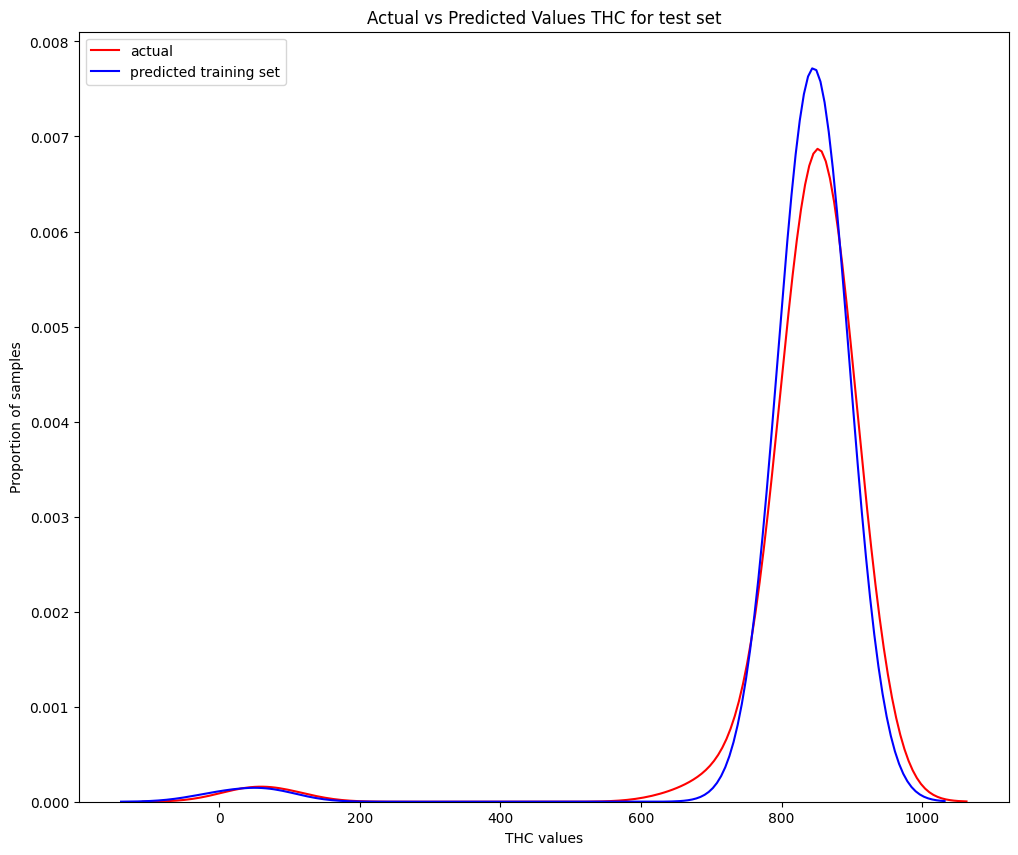

In [154]:
plt.figure(figsize=(12, 10))


ax1 = sns.kdeplot(y_test1, label="actual", color="r") # Actual values of test set
sns.kdeplot(yhat_pr, color="b", label= "predicted training set",ax=ax1) # Predicted values of test set


plt.title('Actual vs Predicted Values THC for test set')
plt.xlabel('THC values')
plt.ylabel('Proportion of samples')
plt.legend()

plt.show()
plt.close()

In [157]:
 # accuracy of actual potency versus predicted potency of train set 
from sklearn.metrics import r2_score
round(r2_score(y_train1, poly.predict(x_train_pr1)), 4)

0.7886

In [156]:
# accuracy of actual potency versus predicted potency of test set 
round(r2_score(y_test1, yhat_pr),4)

0.9208

In [148]:
# or 
round(poly.score(x_test_pr1, y_test1),4)

0.9199

In [633]:
print("Slope:", poly.coef_)
print("Intercept:", poly.intercept_)

Slope: [ 0.00000000e+00 -5.36232890e+00  1.00371912e-02 -5.72735881e-06]
Intercept: 897.5515000049668


### Predictions on Unknown Samples

In [159]:
cbn_value = [10]

pred2array = [cbn_value]
potency = poly.predict(pr.fit_transform(pred2array))
print("The potency value for a CBN value of ", pred2array,"mg/g is:",potency,"mg/g")

The potency value for a CBN value of  [[10]] mg/g is: [844.92620275] mg/g


In [160]:
#from sklearn.model_selection import cross_val_score
#Rcross = cross_val_score(pipe, x_data1[['CBNmg/g']], y_data1, cv=8)
#Rcross

In [169]:
print("predicted values:", Yhat[0:10])
print("Predicted train values:", yhat_pr[0:10])
print("True values:", y_test1[0:10].values)

predicted values: [853.93837047 853.93837047 853.93837047 853.93837047 853.93837047
 853.93837047 853.93837047 846.16258516 841.44476291 849.36376641]
Predicted train values: [831.10257086 865.24806542 874.97834553 821.76372436 807.24512701
 874.60791704 836.83282042 821.21986399 848.5324083  839.66217648]
True values: [832.6565 871.8032 806.4048 855.1222 814.1235 843.1425 848.337  881.6915
 880.029  870.0795]


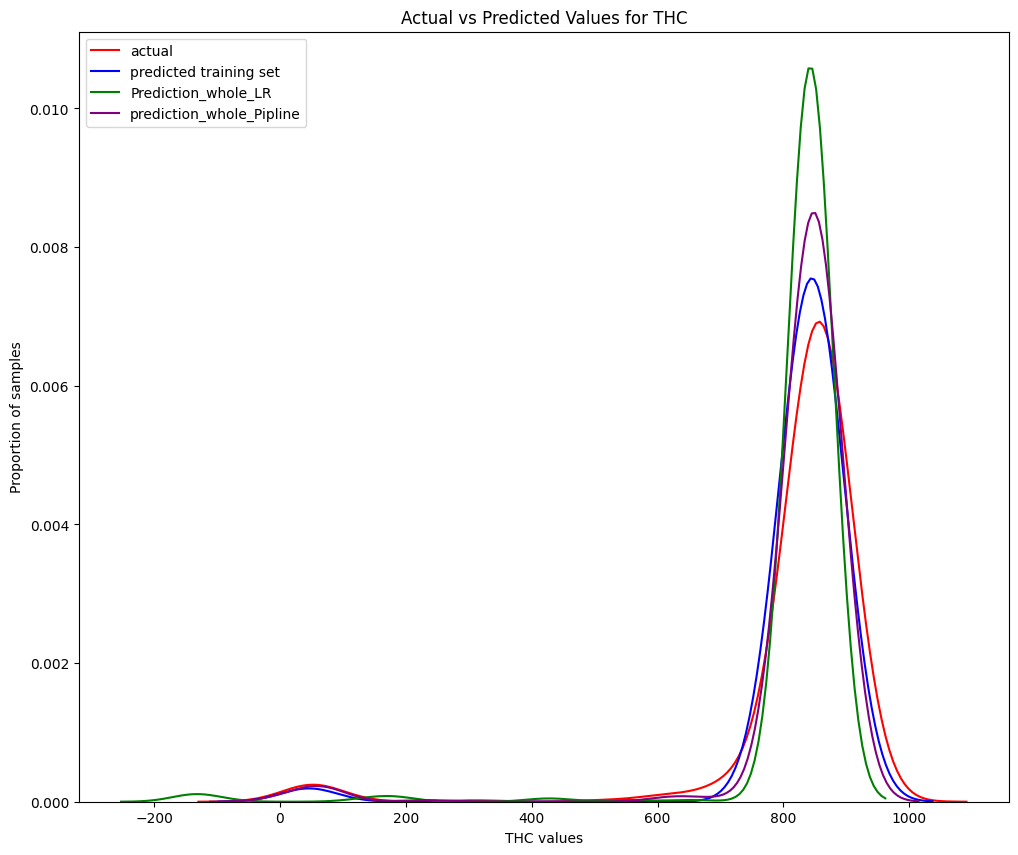

In [601]:
plt.figure(figsize=(12, 10))


ax1 = sns.kdeplot(df_TDT[' ∆9-THC (mg/g)'], label="actual", color="r") # True whole dataset distribution
sns.kdeplot(yhat_pr, color="b", label= "predicted training set",ax=ax1) # Prediction on the training set distribution after splitting into train/test set
sns.kdeplot(Yhat, color="g", label="Prediction_whole_LR", ax=ax1) # Prediction on the whole data before splitting into train and test set with Linear regression only
sns.kdeplot(ypipe, color="purple", label="prediction_whole_Pipline", ax=ax1)  # Prediction on the whole data before test-train split using pipline (applying robustscaler and polynomial function)


plt.title('Actual vs Predicted Values for THC')
plt.xlabel('THC values')
plt.ylabel('Proportion of samples')
plt.legend()

plt.show()
plt.close()

## Conclusion
In conclusion, this project represents a significant stride toward addressing the issue of THC inflation within the cannabis industry. The developed predictive model, which accurately predicts THC values in cannabis distillates with impressive precision well within the margin of error, stands as a potent tool for bolstering transparency and reliability. Its ability to pinpoint instances where THC values deviate from expected norms not only safeguards against inflated THC data but also serves as a crucial quality assurance mechanism for testing laboratories. This multifaceted approach not only ensures consumer trust and satisfaction but also contributes to the broader goal of advancing industry standards and best practices. By enhancing the accuracy of reported THC values and providing checks and balances for quality assurance, this model heralds a promising future for the cannabis testing landscape.<br>

As the cannabis industry continues to evolve, the importance of accurate potency testing cannot be overstated. This project not only provides a solution to the problem of inflated THC values but also empowers industry stakeholders, including producers, consumers, and regulatory bodies, to make informed decisions based on reliable data. With its robust performance and capacity to uphold quality standards, the model not only stands as a testament to innovation but also as a vital tool for fostering trust, accountability, and the continued growth of the cannabis sector

In [171]:
df.to_csv('potency_processed.csv')
